Import Data
--

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

Drought-Index-Function
--

In [119]:
#Rainfall Anomaly Index Function
class drought_indices:
    def open_file(path='/home/okrah/Desktop/DATASETS/', data=None, fname='/precip.mon.mean.nc'):
        file = xr.open_dataset(path+data.upper()+fname)
        return file

    def RAI_XD(data, dimension):
        overall_mean = data.mean(dimension)     #overall mean in the formula is N_bar
        anomaly = data - overall_mean    #the anomaly will be given by difference b/n each value of rainfall in 
                                         #the data array and the overll_mean
                                         #the anomaly in the formula the the N-N_bar(numerator)   
        sortings = data.reduce(np.sort,dim=dimension)  
        da_lowest_10 = sortings[:10].mean(dimension)    #this will give the mean of 10 lowest yearly/monthly precip
                                                        #the da_lowest in the formula is X_bar
        da_highest_10 = sortings[:-10:-1].mean(dimension) #this will give the mean of 10 highest yearly/monthly precip
                                                          #the da_lowest in the formula is M_ba
        negatives = -3*( (anomaly.where(anomaly<0)) / (da_lowest_10-overall_mean) ) #if the anomalies gives negative values
                                                                                    #this formula should be used 
        positives = 3*( (anomaly.where(anomaly>0)) / (da_highest_10-overall_mean) ) #if the anomalies gives positive values,
                                                                                    #this formula should be used
        RAI = anomaly.where(anomaly>=0, negatives).where(anomaly<0, positives)   # after all the calculation, both the 
                                     #negatve and positives anomalies index will be put together and assigned to RAI
        return RAI
    
    
    def anomaly(x):
        return x - np.nanmean(x)

    def RAI(data):
        #Point Location
        N_bar = data.mean()
        X_bar = data.sort_values().head(10).mean()
        M_bar = data.sort_values(ascending=False).head(10).mean()
        anom = drought_indices.anomaly(data)
        positive = anom.loc[anom>=0]
        negative = anom.loc[anom<0]
        p=3*((positive)/(M_bar-N_bar))
        n=-3*((negative)/(X_bar-N_bar))        
        c = pd.concat([p,n]).sort_index()
        return c

Read Datasets
--

Gauge Locations
--

In [491]:
gauge = pd.read_csv('GMet_location_avgSI.txt', usecols=[0,1,2,4], sep='\s+', header=None)
gauge.columns=['station','lon','lat','zone']

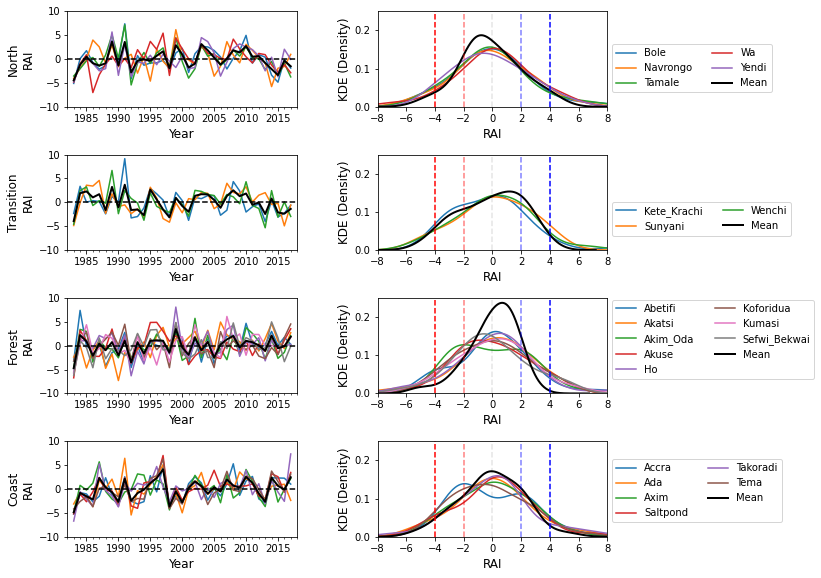

In [561]:
labels = ['North','Transition','Forest','Coast']
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,10))
plt.subplots_adjust(bottom=0.15, right=0.75, wspace=0.35, hspace=0.5)
for i, zone in enumerate(['N','T','F','C']):  #list(set(gauge.zone))):
    gauges = pd.DataFrame(pd.date_range(start='1983-01-01', end='2017-12-31', freq='Y'), columns=['Time'] ).set_index('Time')
    stations=gauge['station'].where(gauge.zone==zone).dropna().values
    for s, station in enumerate(sorted(stations)):
        data = pd.read_csv('DATASETS/GAUGE/'+station+'_1983_2017_dRR_gapless.txt', sep='\s+', usecols=[0, 3], header=None)
        data.columns=['Year','RR']
        data = data.set_index('Year').groupby('Year').sum()
        gauges.loc[:,station] = drought_indices.RAI(data['RR']).values

        
        
    gauges.plot(legend=False, ax=axes[i, 0] )
    gauges.mean(axis=1).plot(color='k', linewidth=2, ax =axes[i, 0], label='Mean')
    axes[i, 0].set_ylabel([l for l in labels if l.startswith(zone) ][0]+'\nRAI', fontsize=12)
    axes[i, 0].set_xlabel('Year', fontsize=12)
    axes[i, 0].set_ylim(-10,10)
    axes[i, 0].set_xlim('1982','2018')
    axes[i, 0].axhline(y=0, color='k', linestyle='dashed', alpha=1)

    

    a = gauges.plot(kind = 'kde', legend=False, ax=axes[i, 1] )
    gauges.median(axis=1).plot(kind = 'kde', color='k', linewidth=2, legend=False, ax=axes[i, 1], label='Mean')
    axes[i, 1].set_xlabel('RAI', fontsize=12)
    axes[i, 1].set_ylabel('KDE (Density)', fontsize=12)
    axes[i, 1].set_xlim(-8,8)
    axes[i, 1].set_ylim(0,0.25)
    axes[i, 1].set_xticks(np.arange(-8,8.1,2))
    axes[i, 1].legend(loc=0, ncol=2, bbox_to_anchor=(1, 0.1))
    
    #### (Normal)
    axes[i, 1].axvline(x=0, color='k', linestyle='dashed', alpha=0.1)

    axes[i, 1].axvline(x=-2, color='r', linestyle='dashed', alpha=0.5)
    axes[i, 1].axvline(x=-4, color='r', linestyle='dashed', alpha=1)

    axes[i, 1].axvline(x=2, color='b', linestyle='dashed', alpha=0.5)
    axes[i, 1].axvline(x=4, color='b', linestyle='dashed', alpha=1)

plt.savefig('Figures/zone_gauge_RAI.pdf')    

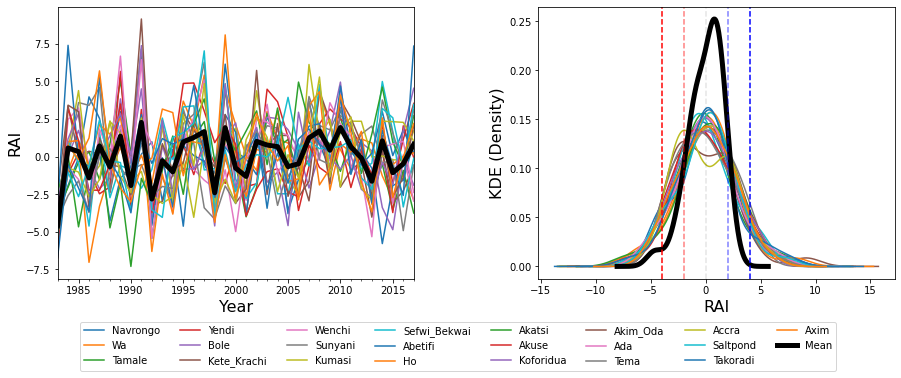

In [577]:
gauges = pd.DataFrame(pd.date_range(start='1983-01-01', end='2017-12-31', freq='Y'), columns=['Time'] ).set_index('Time')
for s, station in enumerate(gauge.station):
    data = pd.read_csv('DATASETS/GAUGE/'+station+'_1983_2017_dRR_gapless.txt', sep='\s+', usecols=[0, 3], header=None)
    data.columns=['Year','RR']
    data = data.set_index('Year').groupby('Year').sum()
    gauges.loc[:,station] = drought_indices.RAI(data['RR']).values
fig, axes = plt.subplots(ncols=2, figsize=(15,6))
plt.subplots_adjust(bottom=0.25, wspace=0.35, )
gauges.plot(legend=False, ax=axes[0] )
gauges.mean(axis=1).plot(color='k', linewidth=5, ax =axes[0], label='Mean')
axes[0].set_ylabel('RAI', fontsize=16)
axes[0].set_xlabel('Year', fontsize=16)
axes[0].legend(loc=0, ncol=8, bbox_to_anchor=(2.2, -0.14))


a = gauges.plot(kind = 'kde', legend=False, ax=axes[1] )
gauges.mean(axis=1).plot(kind = 'kde', color='k', linewidth=5, legend=False, ax=axes[1], label='Mean')
axes[1].set_xlabel('RAI', fontsize=16)
axes[1].set_ylabel('KDE (Density)', fontsize=16)


#### (Normal)
plt.axvline(x=0, color='k', linestyle='dashed', alpha=0.1)

plt.axvline(x=-2, color='r', linestyle='dashed', alpha=0.5)
plt.axvline(x=-4, color='r', linestyle='dashed', alpha=1)

plt.axvline(x=2, color='b', linestyle='dashed', alpha=0.5)
plt.axvline(x=4, color='b', linestyle='dashed', alpha=1)




plt.savefig('Figures/gauge_RAI.pdf')

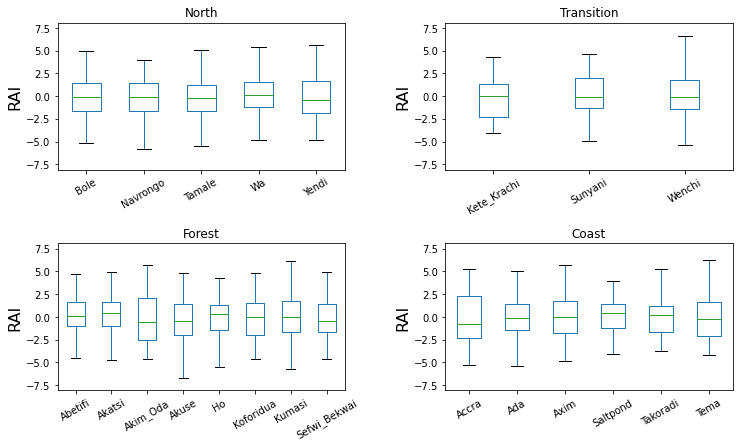

In [574]:
labels = ['North','Transition','Forest','Coast']
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,7))
plt.subplots_adjust(bottom=0.15, right=0.75, wspace=0.35, hspace=0.5)
for i, zone in enumerate(['N','T','F','C']):  #list(set(gauge.zone))):
    gauges = pd.DataFrame(pd.date_range(start='1983-01-01', end='2017-12-31', freq='Y'), columns=['Time'] ).set_index('Time')
    stations=gauge['station'].where(gauge.zone==zone).dropna().values
    for s, station in enumerate(sorted(stations)):
        data = pd.read_csv('DATASETS/GAUGE/'+station+'_1983_2017_dRR_gapless.txt', sep='\s+', usecols=[0, 3], header=None)
        data.columns=['Year','RR']
        data = data.set_index('Year').groupby('Year').sum()
        gauges.loc[:,station] = drought_indices.RAI(data['RR']).values

    #axes[i//2,i%2].axhline(y=0, color='k', linestyle='dashed', alpha=0.5)
    gauges.plot.box(ax = axes[i//2,i%2], showfliers=False, rot=30)
    axes[i//2,i%2].set_ylabel('RAI', fontsize=16)
    
    axes[i//2,i%2].set_title(labels[i])
    axes[i//2,i%2].set_ylim(-8.1,8.1)


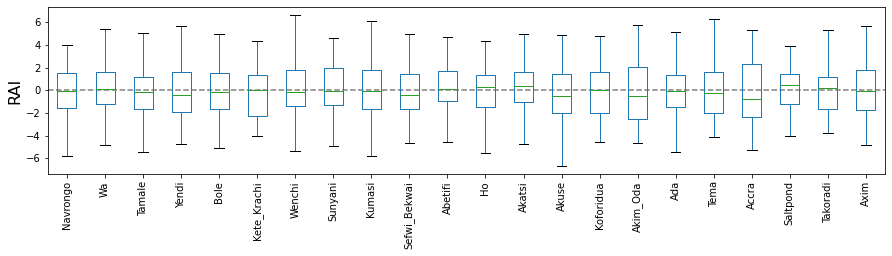

In [578]:
fig, ax = plt.subplots(figsize=(15,4))
plt.subplots_adjust(bottom=0.3)
plt.axhline(y=0, color='k', linestyle='dashed', alpha=0.5)
gauges.plot.box(ax = ax, showfliers=False, rot=90)
plt.ylabel('RAI', fontsize=16)
plt.savefig('Figures/gauge_RAI_box-whisker.pdf')

Spatial Representation of Gauge-based RAI
--

In [341]:
from cartopy import crs as ccrs
from cartopy import feature as cf

In [445]:
extreme_drought = gauges.where(gauges<=-4).count(axis=0) / gauges.count(axis=0)
dry = (gauges.where(gauges<=-2).count(axis=0) / gauges.count(axis=0)) - extreme_drought


extreme_flood = gauges.where(gauges>=4).count(axis=0) / gauges.count(axis=0)
flood = (gauges.where(gauges>=2).count(axis=0) / gauges.count(axis=0)) - extreme_flood

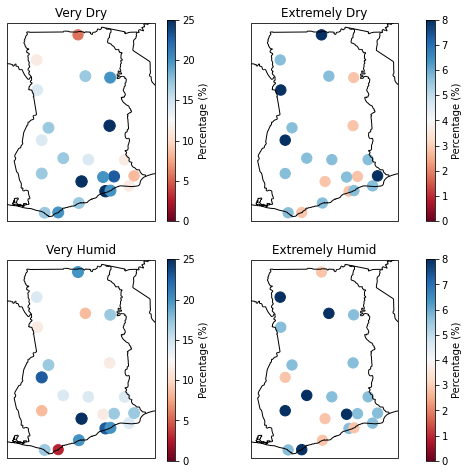

In [458]:
locators = gauge.sort_values('station')

variables = [dry, extreme_drought, flood, extreme_flood]
labels = ['Very Dry','Extremely Dry','Very Humid','Extremely Humid']
maximums = [25, 8, 25, 8]
fig, axes = plt.subplots(ncols=2, nrows=2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(8, 8))
count = 0
for axis in axes:
    for ax in axis:
        ax.coastlines()
        ax.add_feature(cf.BORDERS)
        ax.set_extent([-3.5, 1.5, 4.6,11.3])
        #variables[count].plot.scatter(x=locators['lon'], y=locators['lat'])
        cb = ax.scatter(locators['lon'], locators['lat'], s=100+(variables[count]*100), c=variables[count]*100, cmap='RdBu', vmin=0, vmax=maximums[count])
        #ax.set_colorbar()
        ax.set_title(labels[count])

        if count<2:
            cax = fig.add_axes([0.9/(2-(count%2)), 0.536, 0.015, 0.35])
        else:
            cax = fig.add_axes([0.9/(2-(count%2)), 0.12, 0.015, 0.35])
            
        fig.colorbar(cb, cax=cax, orientation='vertical', label="Percentage (%)")
        count+=1
        
#plt.savefig('Figures/Drought-and-Flood-Events.pdf')

Gridded Data
--

In [581]:
data_names = ['CRU','GPCC', 'GPCP', 'CHIRPS', 'ERA5', 'CMORPH', 'PERSIANN', 'TAMSAT', 'IMERG']
filenames = ['cru_ts4.05.1901.2020.pre.dat.nc','precip.mon.mean.nc','precip.mon.mean.nc']

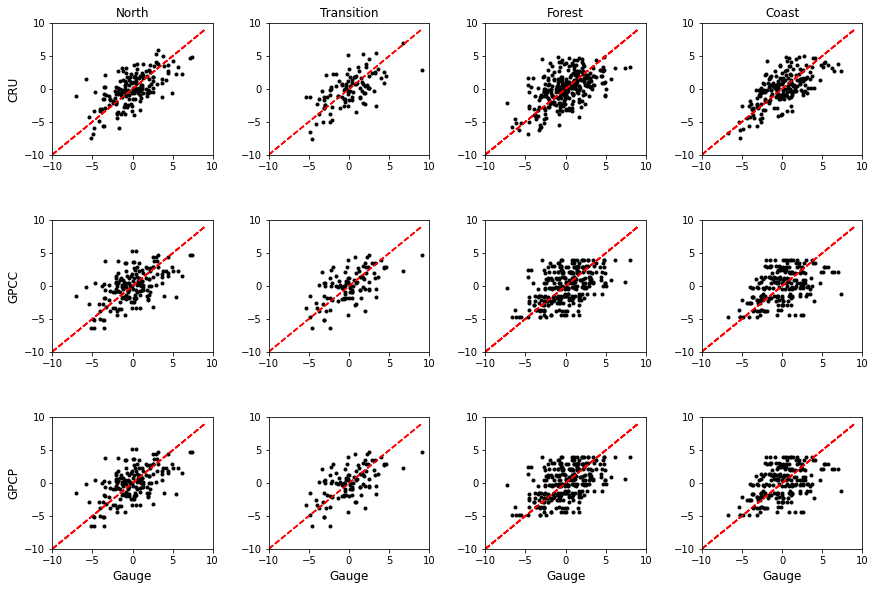

In [793]:
import os
path = os.getcwd()

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(18,10))
plt.subplots_adjust(bottom=0.15, right=0.75, wspace=0.35, hspace=0.5)


RAI_files = ['RAI_'+d for d in data_names]
for i, data in enumerate(data_names[:3]): #Datanames Subsetting Here
    dataset = drought_indices.open_file(path=path+'/DATASETS/', data=data, fname='/'+filenames[i])
    if data == 'CRU':
        dataset = dataset.pre.sel(lon=slice(-3.5,1.5), lat=slice(4,12), time=slice('1983','2017'))
    else:
        dataset = dataset.precip.sel(lon=slice(-3,1.5), lat=slice(4,12), time=slice('1983','2017'))
    dataset = dataset.groupby('time.year').sum('time').rename({'year':'time'})
    RAI_files[i] = drought_indices.RAI_XD(dataset, 'time')

    for x,gdata in enumerate(gauge.station):
        griddata_2_compare = RAI_files[i].sel(lon=gauge.lon[x],lat=gauge.lat[x], method='nearest')
        if gauge.zone[x] == 'N':
            a=0
            #gauge_north
        elif gauge.zone[x] == 'T':
            a=1
        elif gauge.zone[x] == 'F':
            a=2
        else:
            a=3
        #griddata_2_compare.plot(ax=axes[i,a])
        
        axes[i,a].plot(gauges[gdata],griddata_2_compare,'k.')
        xy_line = 10
        axes[i,a].plot(range(-xy_line,xy_line),range(-xy_line,xy_line),'r--', label='x=y')
        axes[i,a].set_ylim(-xy_line,xy_line)
        axes[i,a].set_xlim(-xy_line,xy_line)
        
        if i==0:
            axes[i,a].set_title(labels[a])
            
        if a==0:
            axes[i,a].set_ylabel(data, fontsize=12)
            
        if i == int(len(fig.get_axes())/4)-1:
            axes[i,a].set_xlabel('Gauge', fontsize=12)
        #if i==0 and a==0:
        #    axes[0,0].legend()
            


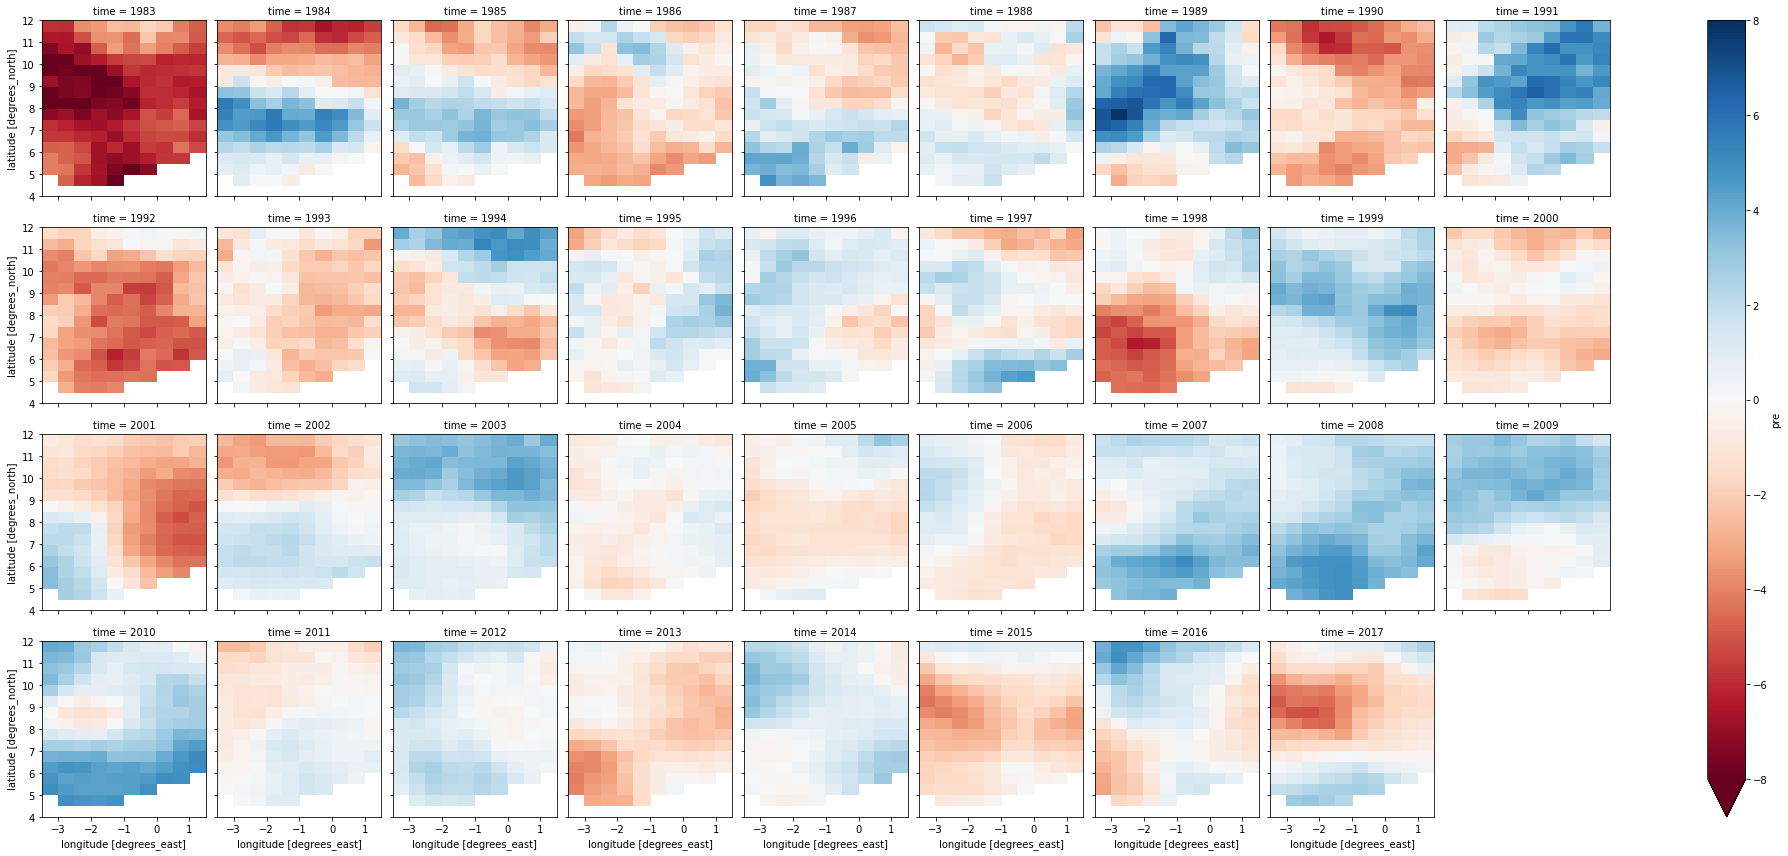

In [782]:
a.plot(col='time', col_wrap=9, vmax=8, vmin=-8, cmap='RdBu')